## Google Driveのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## データセットの準備

In [ ]:
# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d ashaheedq/video-games-sales-2019 -p /content/drive/MyDrive/kaggle

# 解凍
!unzip /content/drive/MyDrive/kaggle/video-games-sales-2019.zip -d /content/drive/MyDrive/kaggle

!rm /content/drive/MyDrive/kaggle/video-games-sales-2019.zip

mkdir: cannot create directory ‘/root/.kaggle’: File exists
  0% 0.00/3.98M [00:00<?, ?B/s]
100% 3.98M/3.98M [00:00<00:00, 64.0MB/s]
Archive:  /content/drive/MyDrive/kaggle/video-games-sales-2019.zip
replace /content/drive/MyDrive/kaggle/vgsales-12-4-2019-short.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


## データの読込

In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/kaggle/vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


### 欠損値の補完

In [ ]:
!pip install datawig
!pip install category_encoders

In [ ]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
from natsort import natsorted 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

from sklearn.impute import SimpleImputer
import datawig

import warnings
warnings.simplefilter('ignore')

In [ ]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

## 欠損値の補完

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [ ]:
print("X_train")
display(pd.DataFrame(X_train.isnull().sum()).T)

print("X_test")
display(pd.DataFrame(X_test.isnull().sum()).T)

print("y_train")
print(y_train.isnull().sum())

print("y_test")
print(y_test.isnull().sum())

X_train


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Year,Last_Update,url,status,Vgchartzscore,img_url
0,0,0,0,0,3911,0,0,3,13590,10599,13480,13590,29,10929,0,0,13270,0


X_test


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Year,Last_Update,url,status,Vgchartzscore,img_url
0,0,0,0,0,1694,0,0,1,5825,4541,5763,5825,9,4673,0,0,5694,0


y_train
0
y_test
0


### dropna

In [ ]:
X_train_drop = X_train.dropna(axis=1, how='any')
X_test_drop = X_test.dropna(axis=1, how='any')

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131719	Test's rmse: 0.206367


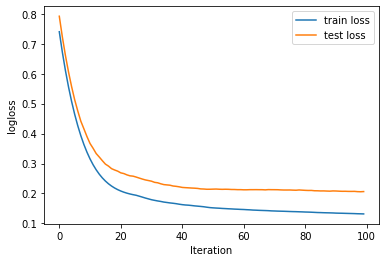

RMSE: 0.2063668889048658


In [ ]:
#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_drop.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_drop[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_drop.copy()
X_test_ce = X_test_drop.copy()


# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )


# 学習、推論
lgb_train = lgb.Dataset(X_train_ce, y_train)
lgb_test = lgb.Dataset(X_test_ce, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_ce)

rmse_drop = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_drop)

### fillna median

In [ ]:
X_train_med = X_train.fillna(X_train.mode())
X_test_med = X_test.fillna(X_test.mode())

Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134021	Test's rmse: 0.226488


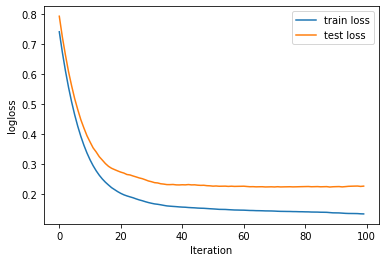

RMSE: 0.22648763368118405


In [ ]:
#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_med.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_med[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_med.copy()
X_test_ce = X_test_med.copy()


# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )


# 学習、推論
lgb_train = lgb.Dataset(X_train_ce, y_train)
lgb_test = lgb.Dataset(X_test_ce, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_ce)

rmse_md = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_md)

### fillna、ffill

In [ ]:
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[38]	Train's rmse: 0.153892	Test's rmse: 0.227949


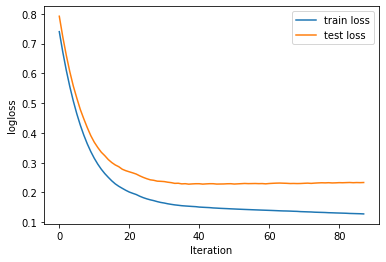

RMSE: 0.2279492669106465


In [ ]:
#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()


# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )


# 学習、推論
lgb_train = lgb.Dataset(X_train_ce, y_train)
lgb_test = lgb.Dataset(X_test_ce, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_ce)

rmse_ff = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_ff)

### SimpleImputer

In [ ]:
imp = SimpleImputer(
    missing_values=np.nan, 
    strategy='constant',
    fill_value=-9999
    )

X_train_imp_cst = pd.DataFrame(
                            imp.fit_transform(X_train),
                            columns = X_train.columns
                        )

X_test_imp_cst = pd.DataFrame(
                            imp.transform(X_test),
                            columns = X_test.columns
                        )

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	Train's rmse: 0.740028	Test's rmse: 1.22226


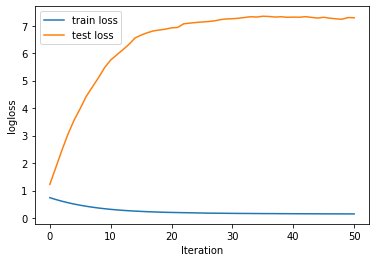

RMSE: 1.2222641644485082


In [ ]:
#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_imp_cst.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_imp_cst[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_imp_cst.copy()
X_test_ce = X_test_imp_cst.copy()


# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )


# 学習、推論
lgb_train = lgb.Dataset(X_train_ce, y_train)
lgb_test = lgb.Dataset(X_test_ce, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_ce)

rmse_imp_cst = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_imp_cst)

## DataWig

In [ ]:
null_columns =X_train.dropna(how="all", axis=1).isnull().sum()[X_train.isnull().sum() > 0].index.to_list()
null_columns

['ESRB_Rating',
 'Developer',
 'Critic_Score',
 'User_Score',
 'Year',
 'Last_Update',
 'Vgchartzscore']

In [ ]:
# 学習
EPOCH = 5

X_train_wig = X_train.dropna(how="all", axis=1).copy()
X_test_wig = X_test[X_train.dropna(how="all", axis=1).columns].copy()

for column in null_columns:

    print(column, end="")

    imputer = datawig.SimpleImputer(
        input_columns=X_train.columns,
        output_column=column,
    )

    imputer.fit(
        train_df=X_train,
        num_epochs=EPOCH
    )

    # 欠損値に相当する項目の予測
    preds_train = imputer.predict(X_train)
    X_train_wig[column] = preds_train[column +  "_imputed"]

    preds_test = imputer.predict(X_test)
    X_test_wig[column] = preds_test[column +  "_imputed"]

    print(" is done!")

ESRB_Rating is done!
Developer is done!
Critic_Score is done!
User_Score is done!
Year is done!
Last_Update is done!
Vgchartzscore is done!


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[49]	Train's rmse: 0.154505	Test's rmse: 0.22671


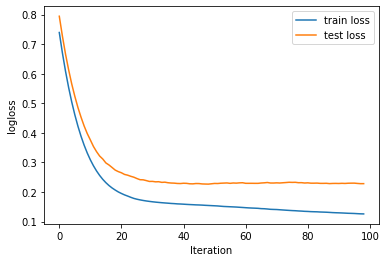

RMSE: 0.22670957239246292


In [ ]:
#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_wig.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_wig[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_wig.copy()
X_test_ce = X_test_wig.copy()


# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )


# 学習、推論
lgb_train = lgb.Dataset(X_train_ce, y_train)
lgb_test = lgb.Dataset(X_test_ce, y_test, reference=lgb_train)

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': {'rmse'},              # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

lgb_results = {}                                    # 学習の履歴を入れる入物

model = lgb.train(
                  params=params,                    # ハイパーパラメータをセット
                  train_set=lgb_train,              # 訓練データを訓練用にセット
                  valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                  valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                  num_boost_round=100,              # 計算回数
                  early_stopping_rounds=50,         # アーリーストッピング設定
                  evals_result=lgb_results,
                  verbose_eval=-1,                           # ログを最後の1つだけ表示
                  )

# 損失推移を表示
loss_train = lgb_results['Train']['rmse']
loss_test = lgb_results['Test']['rmse']   
  
fig = plt.figure()
  
plt.xlabel('Iteration')
plt.ylabel('logloss')
 
plt.plot(loss_train, label='train loss')
plt.plot(loss_test, label='test loss')
 
plt.legend()
plt.show()

# 推論
y_pred = model.predict(X_test_ce)

rmse_wig = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse_wig)

In [ ]:
print("dropna RMSE:", round(rmse_drop, 3))
print("fillna median RMSE:", round(rmse_md, 3))
print("fillna ffill RMSE:", round(rmse_ff, 3))
print("SimpleImputer constant RMSE:", round(rmse_imp_cst, 3))
print("DataWig RMSE:", round(rmse_wig, 3))

dropna RMSE: 0.206
fillna median RMSE: 0.226
fillna ffill RMSE: 0.228
SimpleImputer constant RMSE: 1.222
DataWig RMSE: 0.227
